Original notebook:https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-5/tracking/RNN_practice.ipynb
MLHEP 2019, day 5, tracking

In [0]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py

--2019-07-15 13:30:47--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374 [text/plain]
Saving to: ‘metrics.py’

metrics.py          100%[===================>]     374  --.-KB/s    in 0s      

2019-07-15 13:30:47 (61.8 MB/s) - ‘metrics.py’ saved [374/374]



In [0]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py

--2019-07-15 13:30:49--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6143 (6.0K) [text/plain]
Saving to: ‘user_test_submission.py’

user_test_submissio 100%[===================>]   6.00K  --.-KB/s    in 0s      

2019-07-15 13:30:49 (89.3 MB/s) - ‘user_test_submission.py’ saved [6143/6143]



In [0]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv

--2019-07-15 13:30:51--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18420554 (18M) [text/plain]
Saving to: ‘public_train.csv’

public_train.csv    100%[===================>]  17.57M  --.-KB/s    in 0.1s    

2019-07-15 13:30:51 (132 MB/s) - ‘public_train.csv’ saved [18420554/18420554]



In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

import user_test_submission as submission

In [0]:
import numpy as np
import math
from metrics import predictor
from sklearn.base import BaseEstimator

# Track Pattern Recognition using Linear Approximation of a Track
Original competition: https://ramp.studio/problems/HEP_tracking


素粒子物理学では、各検出器で再構成されたヒットを元に、どのヒットがどの粒子由来かを分類する、「パターン認識（Pattarn Recognition）」が重要である。

ここでは2D でのパターン認識を、RNNを用いて高い効率で行うことを目標にする。


## 目標

この章の大目的は、1イベント内にあるヒットを、正しく分類し、クラスターとして組み合わせることである。検出器内のヒット位置という情報がインプットとして与えられているので、クラスタリングのスキームを実装し、全てのヒットに対し、cluster idを割り振りたい。その上で、そのクラスターがどの程度、インプットとなった粒子と対応しているかを評価する、スコア関数を設定する。

## 実装

ここではcluster.pyというクラスを実装する。この関数は、`__init__`、`fit`、そして `predict_single_event`という関数を持つ。

* **`__init__`**　ではパラメーターがセットされる。
* **`fit`** は訓練用の関数である（トラックフィッティングのことではない）。そのため、この関数は ground-truthにアクセスする必要がある。この関数は、訓練用のデータを含むインプットを受け取ったときに走らせる関数であり、イベントレベル、粒子レベルでの訓練どちらにも対応できるべきである。
* **`predict_single_event`** はクラスター（トラックの候補）を再構成、すなわち予測したいヒットにクラスターIDを割り振ったものを返す関数である。ここでは「予測」と「再構成」が大体同じ文脈で使われる。This function takes only the hits from a single event as input, with the event_id dropped, and the RAMP machinery takes care of running this function on each event.

The **task**  is to implement this class in a way that the predict_single_event function returns a numpy array of assigned cluster ids. At any level of this task, machine-learning techniques can be employed for sub-tasks defined by the user.

## 検出器について

提供されるデータはATLAS検出器(シリコン検出器)のデザインを真似たシンプルなトイモデルから生成された、ヒット位置のリストである。検出器は玉ねぎのような構造をしており、原点を9層の検出層（$R = [39,85,155,213,271,405,562,762,1000]$ cm）が覆う。検出層の厚さは距離に対して非常に薄いため、無視できる。 

各検出層は高い粒度で方位角方向に細分化されている。各層には
 ($2\pi$R/pitch)+1 個のピクセルが配置されており、それぞれのピッチは0から4層目までが0.025 cm、5から9層目までが0.05 cmである。

## シミュレーションについて

Taskクラスは粒子の生成とシミュレーションにトイモデルを用いている。トイモデルでは、各イベントごとの粒子数を決めるのに、平均10のポアソン分布を使ってサンプリングをしている。

各粒子については、運動量に関する束縛条件のもとで、運動量と方位角に関しては一様分布からサンプルを行っている。それぞれの粒子はバーテックス（原点周りの狭い正規分布からサンプル）から生じている。この位置や運動量を正確に求める（すなわち、軌跡を再構成する）というのは、このノートブックでは行わない。あくまでこのノートブックではパターン認識に重きを置く。
 
粒子は一様磁場の中で運動する。物質による多重散乱に関しては考慮しており、検出器の位置での運動量のランダムな回転として実装されている。

また、検出器の無効効率に関しても再現しており（3%）、粒子のハドロン反応によるstopping probability（1%）も考慮している。しかしながら、こうしたアルゴリズムはヒットの無い層が複数あったとしても正しく働くことを期待されることに注意しなければならない。一方で、粒子のパイルアップに関しては、粒度の高いデザインを採用したことで無視して良い（0.2%程度）。




In [0]:
!sudo pip install sklearn==0.18.1

  ERROR: Could not find a version that satisfies the requirement sklearn==0.18.1 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.18.1


# 入力データの処理

入力データの処理にはpandasのパッケージを用いる。

In [0]:
data = pandas.read_csv('public_train.csv', index_col=False)

data.head()

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583


## データの確認

### Data Preparation

In [0]:
X = data.drop(['cluster_id'], axis=1).values # XにクラスターIDを落としたものをコピーする
y = data[['event_id', 'cluster_id']].values
print(y.shape)

(418059, 2)


### Visualize the hits in a single event

In [0]:
# イベントID(0列目の全ての要素)
event_ids = X[:, 0]

# 重複を許さないイベントIDの行列を準備する
unique_event_ids = np.unique(event_ids)

i_event = unique_event_ids[1]
X_event = X[event_ids == i_event]
y_event = y[event_ids == i_event]
print(i_event)
print(y_event.shape)

4.0
(94, 2)


In [0]:
def plot_event(X, y=None, is_plot=True):
    
    cmap = ['k', 'b', 'y', 'g', 'r', 'k']
    R=[39, 85, 155, 213, 271, 405, 562, 762, 1000]
    
    hit_x = X[:, 3]
    hit_y = X[:, 4]
    
    plt.figure(figsize=(6, 6))
    # yが値として有れば、そのままxyをプロットする
    # yが無ければ、？？？
    if y is None:
        plt.scatter(hit_x, hit_y)
        
    if y is not None:
        for i_track in np.unique(y):
            track_mask = y == i_track
            track_x = hit_x[track_mask]
            track_y = hit_y[track_mask]
            track_r = np.sqrt(track_x**2 + track_y**2)
            sorted_ids = np.argsort(track_r)
            if is_plot:
                plt.plot(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
            plt.scatter(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
        
    for ar in R:
        circle=plt.Circle((0,0), ar, color='0.5', fill=False) # (0,0)を中心とした、半径Rの円
        plt.gcf().gca().add_artist(circle)
    
    plt.xlim(-1100, 1100)
    plt.ylim(-1100, 1100)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel('X', size=12)
    plt.ylabel('Y', size=12)
    plt.show()

与えられたデータがこれで:


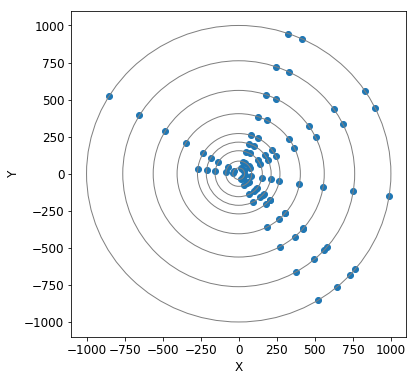

最終的な目的がこのクラシフィケーション:


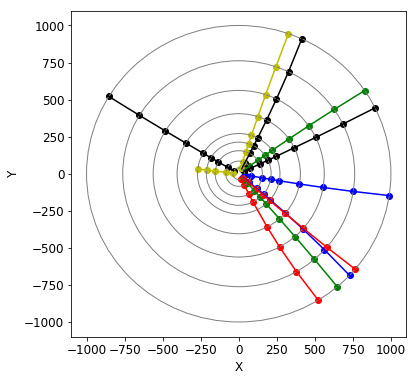

In [0]:
print("与えられたデータがこれで:")
plot_event(X_event, None)

print("最終的な目的がこのクラシフィケーション:")
plot_event(X_event, y_event[:, 1])

## データの前処理
訓練用データとテストデータを切り分ける

In [0]:
from sklearn.model_selection import train_test_split
#sklearnパッケージの切り分け用関数を使う。
event_ids = numpy.unique(data['event_id'].values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=1000, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train)], y[data['event_id'].isin(event_ids_train)]
X_test, y_test   = X[data['event_id'].isin(event_ids_test)],  y[data['event_id'].isin(event_ids_test)]

# クラスタリングに基づく予測

sklearnsのクラスタリングパッケージを使ってみる。

In [0]:
class Clusterer(object):

    def __init__(self, cluster=None):

        self.cluster = cluster

    def get_polar(self, x, y):

        x = numpy.array(x)
        y = numpy.array(y)

        phi = numpy.arctan2(y, x)
        r = numpy.sqrt(x**2 + y**2)

        return r, phi

    
    def fit(self, X, y):
        pass

    
    def predict_single_event(self, X):

        x, y = X[:, 3], X[:, 4]
        r, phi = self.get_polar(x, y)

        self.cluster.fit(phi.reshape(-1, 1))
        labels = self.cluster.labels_
        
        return labels

In [0]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

#ctr = Clusterer(cluster=KMeans(n_clusters=11, n_init=1))
ctr = Clusterer(cluster = DBSCAN(eps=0.1, min_samples=3)) # phiに関するDBSCAN

### Test on single event

Recognized tracks:


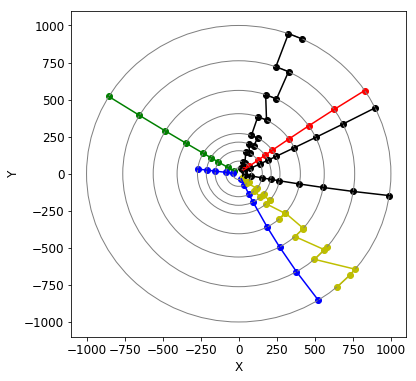

In [0]:
y_event_pred = ctr.predict_single_event(X_event)
y_event_pred
print("Recognized tracks:")
plot_event(X_event, y_event_pred)

### Test on several events

In [0]:
#%%time
#from metrics import predictor
y_pred_test = predictor(ctr, X_test, y_test)
#テストサンプルに対しCPUの計算にかかった時間を教えてくれる

score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8020


# RNN based tracks pattern recognition

Original article: https://www.epj-conferences.org/articles/epjconf/pdf/2017/19/epjconf_ctdw2017_00003.pdf

## 再起型ニューラルネットワーク


従来のNNでは、インプットデータは互いに独立な状態であるという仮定を置いていたのに対し、RNNでは直前の状態を記憶しておき、連続的な要素ごとに同じ作業を行うことができる。

ここでは軌跡を分類するためのLSTMモデル構造を実装する。LSTMと、ソフトマックス活性化関数を用いた全結合層はピクセルアレイを読み込んで、どのピクセルがどの軌跡に属するかを予測する。



<img src="https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-5/tracking/pic/model.png?raw=1" width="600"/> <br>

### LSTM (Long Short Term Memory)


## Data preparation

In [0]:
num_phi_bin = 100

In [0]:
# Data preprocessing functions

class det_geo():
    layer_r     = np.array([39,    85,    155,   213,   271,   405,  562,  762,  1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0.05, 0.05])
    num_layers = layer_r.shape[0]
    max_phi = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)

    
def rescale_phi(phi, nbin, layer):
    return (phi * float(nbin) / det_geo.max_phi[layer.astype(np.int)]).astype(np.int)


def event_hits_transform(X, y=None, num_phi_bin=100):
    
    evids, layers, phis = X[:,0].astype(np.int), X[:,1].astype(np.int), X[:,2].astype(np.int)
    phis = rescale_phi(phis, num_phi_bin, layers)
    
    # 一番目のレイヤーでのヒットを数え、シードとする。
    seed_idx = np.where(layers == 0)[0]
    num_seeds = seed_idx.size

    #　訓練用のインプットは残りのイベントから続くシードヒットを含む
    train_input = np.zeros((num_seeds, det_geo.num_layers, num_phi_bin))
    # 訓練用の目標は信号軌跡の個別の画像である
    train_target = np.zeros_like(train_input)#train_inputと同じ形状の0行列を生成する　

    # 全てのシードに関するループ
    for i_sample in range(num_seeds):
        # i_hitがクラスターのseedのヒット番号
        i_hit = seed_idx[i_sample]

        # 訓練用のインプットの最初のレイヤを、シードヒットで埋める（hit = 1）
        train_input[i_sample, 0, phis[i_hit]] = 1
        # 他の層を、残りのヒットで埋める
        train_input[i_sample, layers[layers > 0], phis[layers > 0]] = 1

        # この軌跡由来のヒットを埋める
        if y is not None:
            track_ids = y[:, 1] # clusteridのアレイをここに詰める
            seed_track_id = y[i_hit, 1] # ihit番目のcluster id
            train_target[i_sample, layers[track_ids == seed_track_id], phis[track_ids == seed_track_id]] = 1
            # i_sampleのクラスター番号に
    return train_input, train_target

In [0]:
# Data visualization function

def plot_event_polar(X):
    
    plt.figure(figsize=(6, 6))
    
    plt.pcolor(X.T)
    
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.xlabel('Layer bins', size=12)
    plt.ylabel('Phi bins', size=12)
    
    plt.show()

### Preprocess one event

In [0]:
# データの前処理
# X_event, y_eventを変換する。X_event_polarがtrain_input、yがtrain_targetに相当
X_event_polar, y_event_polar = event_hits_transform(X_event, y_event, num_phi_bin)
# Display shapes
print(X_event.shape)
print(y_event.shape)
X_event_polar.shape, y_event_polar.shape
print(X_event_polar[0,1,:])
#サイズは、（i_amples(つまり、クラスターの総数)、レイヤー数、ファイのビン数）

(94, 5)
(94, 2)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]


Original event hits:


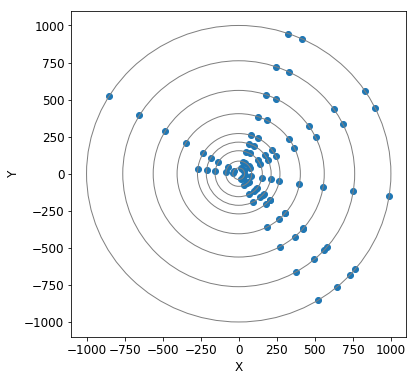

RNN inputs for one track of the event:


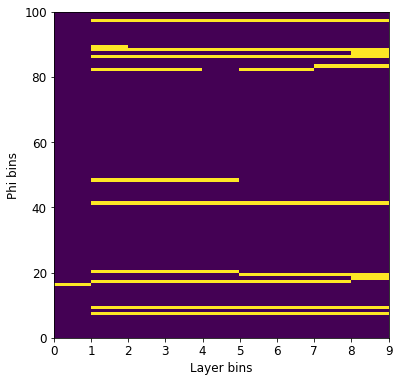

RNN outputs for the track:


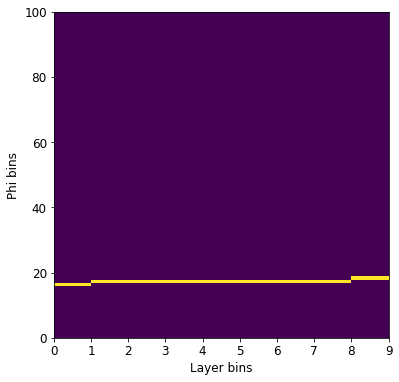

In [0]:
i_train = 0

print("Original event hits:")
plot_event(X_event, None)

print("RNN inputs for one track of the event:")
plot_event_polar(X_event_polar[i_train])

print("RNN outputs for the track:")
plot_event_polar(y_event_polar[i_train])

### Preprocess all training events

In [0]:
# Preprocessing
train_input = []
train_target = []

event_ids = X_train[:, 0]
for i_event in np.unique(event_ids):
    
    # Take one event
    X_ev = X_train[event_ids == i_event]
    y_ev = y_train[event_ids == i_event]

    # Preprocess this event
    train_input_ev, train_target_ev = event_hits_transform(X_ev, y_ev, num_phi_bin)
    
    # Store the preprocessed events
    train_input.append(train_input_ev)
    train_target.append(train_target_ev)

X_train_polar = np.concatenate(tuple(train_input))
y_train_polar = np.concatenate(tuple(train_target))

In [0]:
# Display shapes
X_train_polar.shape, y_train_polar.shape

AttributeError: ignored

## Define RNN model

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook

# Estimate device to train a model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define a model
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTM(100, 150, batch_first=True)
        self.dense1 = nn.Linear(150, 100)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)
 
    def forward(self, x):
        
        hid_sequence, (c_last, h_last) = self.lstm1(x)
        hid_sequence = self.dropout(self.dense1(hid_sequence))
        logits = self.softmax(hid_sequence)
        return logits

## Fit the RNN model

In [0]:
class MyClassifier(object):
    
    def __init__(self, model, n_epochs=10, batch_size=64):
     
        self.model = model
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        
    
    def fit(self, X, y):
          
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_tensor = torch.as_tensor(y, dtype=torch.float32, device=device)
        
        #訓練用のデータセットを作る
        train_data = TensorDataset(X_tensor, y_tensor)
       
        opt = torch.optim.Adam(self.model.parameters())
        self.model.train(True)
        
        # 訓練を行う
        for epoch_i in range(self.n_epochs):
            loss_history = []
            for x_batch, y_batch in tqdm_notebook(DataLoader(train_data, batch_size=self.batch_size, shuffle=True)):
                # make prediction on a batch
                logits = self.model(x_batch)
                # calculate loss
                loss = -(torch.log(logits) * y_batch).sum(-1).mean()
                # set gradients to zero
                opt.zero_grad()
                # backpropagate gradients
                loss.backward()
                # update the model weights
                opt.step()
                loss_history.append(loss.item())
            print("epoch: %i, mean loss: %.5f" % (epoch_i, np.mean(loss_history)))
    
    def predict(self, X):# numpy 
        
        self.model.train(False)       
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_pred = model(X_tensor)
        print(y_pred.shape)
        return y_pred.cpu().detach().numpy()

In [0]:
# Create a pytorch model
model=Model().to(device=device)

# Fit the model
clf = MyClassifier(model=model, n_epochs=50, batch_size=64)
clf.fit(X_train_polar, y_train_polar)


epoch: 0, mean loss: 2.56155



epoch: 1, mean loss: 1.35472



epoch: 2, mean loss: 1.05834



epoch: 3, mean loss: 0.89090



epoch: 4, mean loss: 0.75111



epoch: 5, mean loss: 0.65206



epoch: 6, mean loss: 0.58480



epoch: 7, mean loss: 0.54095



epoch: 8, mean loss: 0.51466



epoch: 9, mean loss: 0.49425



epoch: 10, mean loss: 0.47895



epoch: 11, mean loss: 0.46849



epoch: 12, mean loss: 0.45905



epoch: 13, mean loss: 0.45720



epoch: 14, mean loss: 0.45080



epoch: 15, mean loss: 0.44445



epoch: 16, mean loss: 0.44163



epoch: 17, mean loss: 0.43773



epoch: 18, mean loss: 0.43463



epoch: 19, mean loss: 0.43149



epoch: 20, mean loss: 0.42643



epoch: 21, mean loss: 0.42712



epoch: 22, mean loss: 0.42650



epoch: 23, mean loss: 0.42066



epoch: 24, mean loss: 0.42343



epoch: 25, mean loss: 0.41866



epoch: 26, mean loss: 0.41502



epoch: 27, mean loss: 0.41731



epoch: 28, mean loss: 0.41539



epoch: 29, mean loss: 0.41089



epoch: 30, mean loss: 0.41240



epoch: 31, mean loss: 0.41121



epoch: 32, mean loss: 0.41184



epoch: 33, mean loss: 0.40993



epoch: 34, mean loss: 0.40841



epoch: 35, mean loss: 0.40455



epoch: 36, mean loss: 0.40252



epoch: 37, mean loss: 0.40433



epoch: 38, mean loss: 0.40739



epoch: 39, mean loss: 0.40375



epoch: 40, mean loss: 0.40690



epoch: 41, mean loss: 0.39955



epoch: 42, mean loss: 0.40279



epoch: 43, mean loss: 0.40006



epoch: 44, mean loss: 0.40326



epoch: 45, mean loss: 0.39795



epoch: 46, mean loss: 0.39767



epoch: 47, mean loss: 0.39852



epoch: 48, mean loss: 0.39750



epoch: 49, mean loss: 0.39793


In [0]:
# Make predictions for one event
y_event_polar_pred = clf.predict(X_event_polar)

torch.Size([11, 9, 100])


In [0]:
print(y_event_polar_pred.shape)
print(X_event_polar.shape)

(11, 9, 100)
(11, 9, 100)


RNN output for the track:


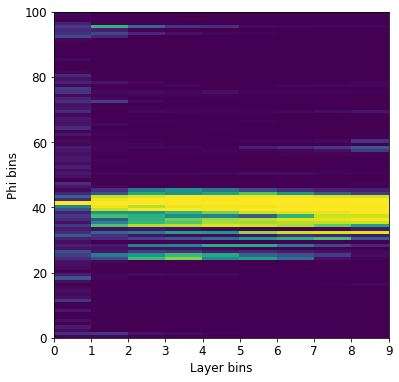

True output for the track:


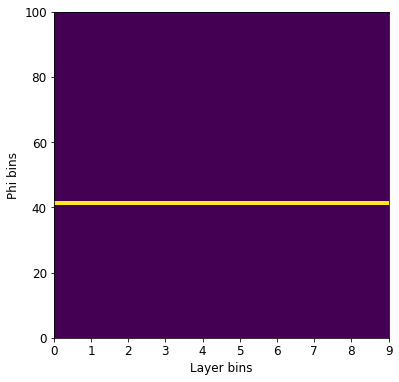

In [0]:
i_train = 1

print("RNN output for the track:")
plot_event_polar(y_event_polar_pred[i_train])

print("True output for the track:")
plot_event_polar(y_event_polar[i_train])

## Test track pattern recognition algorithm

In [0]:
class Clusterer(object):

    def __init__(self, classifier=None):

        self.classifier = classifier
    
    def fit(self, X, y):
        pass

    
    def predict_single_event(self, X):

        trkid = np.zeros(X.shape[0])
        for i in range(trkid.shape[0]):
            
            lays, phis = X[:,1].astype(np.int), X[:,2].astype(np.int)
            phis = rescale_phi(phis, num_phi_bin, lays)
            lay, phi = lays[i], phis[i]
            
            # Preprocess the event
            X_polar, _ = event_hits_transform(X, None, num_phi_bin)
            # Get predictions for the event
            y_polar_pred = clf.predict(X_polar)

            # seedの数だけの大きさの配列。このスコアの要素は、今見ているヒットがどのシードに属するかの確率を表す。
            scores = y_polar_pred[:, lays[i], phis[i]]
            # 最もスコアの高いものを答え（クラスターID）とする
            best = np.argmax(scores)
            trkid[i] = best
            
        return trkid

In [0]:
ctr = Clusterer(classifier=clf)

y_event_pred = ctr.predict_single_event(X_event)
y_event_pred # bestなスコアのtrack id

array([ 9.,  2.,  4.,  6.,  1., 10.,  0.,  9.,  3.,  3.,  4.,  9.,  4.,
        5.,  2.,  0., 10.,  5.,  6.,  1.,  6.,  1.,  8.,  1.,  5.,  0.,
       10.,  5.,  1.,  6.,  2.,  2.,  3.,  9.,  4.,  4.,  0.,  1.,  6.,
        5.,  9.,  6.,  0.,  6.,  3.,  4.,  6.,  2., 10.,  5., 10.,  3.,
        0.,  1.,  6.,  6., 10.,  2.,  0.,  7.,  5., 10.,  7.,  8.,  3.,
        1.,  6.,  6.,  0.,  3.,  6.,  9.,  2.,  9.,  4.,  8.,  4.,  4.,
        9.,  0.,  8.,  6.,  3., 10.,  4.,  8.,  2.,  9.,  3., 10.,  1.,
        5.,  6.,  5.])

Recognized tracks:


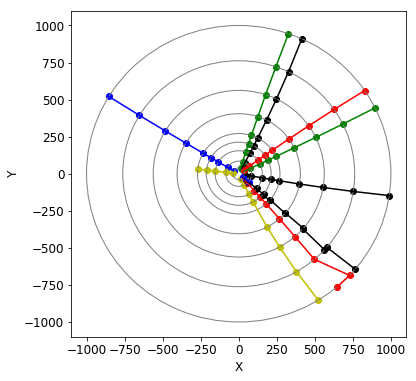

In [0]:
print("Recognized tracks:")
plot_event(X_event, y_event_pred, is_plot=True)

In [0]:
%%time
from metrics import predictor
y_pred_test = predictor(ctr, X_test, y_test)

CPU times: user 1min 16s, sys: 1.86 s, total: 1min 18s
Wall time: 1min 18s


In [0]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8869


# Task 2

Create a deep model with the following layers:
* Input layer
* LSTM with 200 hidden neurons
* 30% dropout
* LSTM with 150 hidden neurons
* 20% dropout
* Output dense layer with 100 neurons and Softmax activation.

In [0]:
# Define a model
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Your code is here ###
 
    def forward(self, x):
        
        ### Your code is here ###
        
        return logits

In [0]:
# Create a pytorch model
### Your code is here ###

# Fit the model
### Your code is here ###

In [0]:
%%time
# Calculate the quality score
### Your code is here ###